<a href="https://colab.research.google.com/github/hiluka/how-to-hyperopt/blob/main/Hyperparameter_Optimisation_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Guide: The Role of Hyperparameters in Machine Learning Models and How to Tune Them

This notebook aims to give guidance for a complete and correct hyperparameter tuning. Both, a correct implementation of GridSearch and Randomsearch will be shown at the example of first an artifical toy data set and an easy real-world dataset.

This guide is structured in the following sections: 

> 0.0 [Required Packages](https://colab.research.google.com/drive1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=Pz2GAGUEHaYv&line=1&uniqifier=1)

Artifical Data:

> 1.1 [Artifical Data Preparation](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=egRFFwdv1uej&line=5&uniqifier=1)

> 1.2 [Data Visualization and Basic Prediction](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=HtOnG2ZnHiQN&line=2&uniqifier=1)

> 1.3 [Hyperparameter Tuning with GridSearch](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=xZJP_i6CwghY&line=5&uniqifier=1)

> 1.4 [Hyperparameter Tuning with Random Search](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=0HGGDqjMCXHl&line=3&uniqifier=1)


Real World Data:

> 2.1 [Real-world Data Preparation](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=HMHrMshEdpxK&line=2&uniqifier=1)

> 2.2 [Random Forest](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=KxmQsc1H5RCd&line=4&uniqifier=1)

> 2.3 [XGBoost](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=kCWHFYRboEAu&line=5&uniqifier=1)

Overfitting/Underfitting Visualization:

> 3.1 [Visualizing the problem of under- and overfitting and how to overcome it](https://colab.research.google.com/drive/1ZwcRoIeugkarU5S5pAyA1L2TNA83LkTI#scrollTo=-UNN1dYIu0GA&line=1&uniqifier=1)



# 0.0 Required Packages

The following packages are all we need for the example:
* pandas (https://pandas.pydata.org/docs/)
* numpy (https://numpy.org/doc/)
* matplotlib (https://matplotlib.org/stable/index.html)
* sklearn (https://scikit-learn.org/stable/)
* xgboost (https://xgboost.readthedocs.io/en/stable/)

They can be automatically installed (if not available) using the package manager *pip* and the following code chunk:

In [1]:
import importlib.util
import os

# Check for missing packages
def check_pkg(package):
  if importlib.util.find_spec(package):
    return(f"{package} already in sys.modules")
  else:
    os.system("pip install {0}".format(package))
    return(f"{package} installed.")

packages = ["pandas", "numpy", "matplotlib", "sklearn", "xgboost"]
[check_pkg(package) for package in packages]

['pandas already in sys.modules',
 'numpy already in sys.modules',
 'matplotlib already in sys.modules',
 'sklearn already in sys.modules',
 'xgboost already in sys.modules']

Having these packages installed, we can import all the modules required to run the example:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_circles
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

# 1.1 Artifical Data Preparation

We generate an artificial dataset with only two variables and a visible data distribution to visulaize the effects of hyperparameter tuning. 

In [3]:
# Sample data from distribution (sklearn)
circles_X, circles_y = make_circles(n_samples=300, noise=0.05, random_state=20220726)
df = pd.DataFrame(dict(x=circles_X[:,0], y=circles_X[:,1], label=circles_y))

# Show data set 
df.head()

,x,y,label
0,-0.586181,-0.493076,1
1,0.615971,-0.855550,0
2,0.574021,0.768072,0
3,-0.785694,0.138116,1
4,0.923278,0.590371,0


The two target classes are distributed along the two variables like two circles.

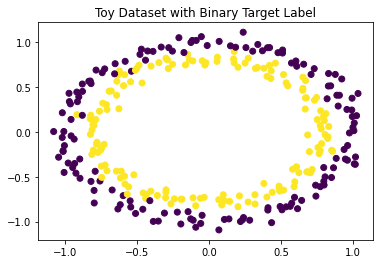

In [4]:
# Plot the data points
plt.scatter(df["x"], df["y"], c=df["label"])
plt.title("Toy Dataset with Binary Target Label")
plt.show()

The two colors visualize our two target labels which we would like to classify based on two features (x and y axis values).

# 1.2 Data Visualization and Basic Prediction

First, we run a support vector classifier (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) without optimizing the hyperparameters. We first train on the model on the train set and then test it on the test set. The plot shows where the model creates decision boundaries.

We highly recommend to read the basics of Support Vector Machines in beforehand:
* *Bernhard E. Boser, Isabelle M. Guyon, and Vladimir N. Vapnik. (1992) A training algorithm for optimal margin classifiers. In Proceedings of the fifth annual workshop on Computational learning theory (COLT '92). Association for Computing Machinery, New York, NY, USA, 144–152. https://doi.org/10.1145/130385.130401*
* *Cristianini N., Ricci E. (2008) Support Vector Machines. In: Kao MY. (eds) Encyclopedia of Algorithms. Springer, Boston, MA. https://doi.org/10.1007/978-0-387-30162-4_415*

In [5]:
# Create Train Test Split
features=["x", "y"]
X_train, X_test, y_train, y_test = train_test_split(df[features], df["label"], test_size=0.2, random_state=0)

# Without Tuning
clf = svm.SVC(kernel="linear").fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print Results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.38074592074592073


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


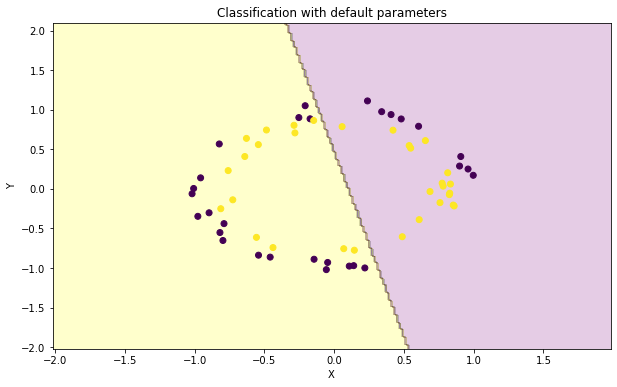

In [6]:
# create a mesh to plot in
x_min, x_max = X_test["x"].min() - 1, X_test["x"].max() + 1
y_min, y_max = X_test["y"].min() - 1, X_test["y"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.2, colors = ['purple', "black", "yellow", "black"])

# Plot also the training points
plt.scatter(X_test["x"], X_test["y"], c=y_test)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification with default parameters")

plt.show()

# 1.3 Hyperparameter Tuning with GridSearch

Now, we optimize the hyperparameters kernel, C and gamma. We define a grid testing the most common values for these parameters. In total, this seach will result in 60 combinations.

Again, we provide you some literature about Grid Search:
* *Liashchynskyi, Petro B. and Pavlo B. Liashchynskyi. (2019) Grid Search, Random Search, Genetic Algorithm: A Big Comparison for NAS. https://arxiv.org/abs/1912.06059*

In [7]:
# Define the search Grid
grid = GridSearchCV(svm.SVC(random_state=0, class_weight="balanced"), # initialize the SVM
                  param_grid = {'kernel': ["rbf", "linear", "poly", "sigmoid"],  # define possible hyperparameter ranges
                                'C': [0.01, 0.1, 1, 10],
                                'gamma': [1, 0.1, 0.01, 0.001]
                                },
                  cv = ShuffleSplit(n_splits=5, random_state=20220715), # define cross-validation splits with random seed
                  verbose=10,                     
                  scoring='f1_micro',
                  n_jobs=-1)

# Run the GridSearch
results = grid.fit(X_train, y_train)
grid_results = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)



Fitting 5 folds for each of 64 candidates, totalling 320 fits


The results show how the optimized hyperparameters lead to better fitting decision boundaries and a better classification accuracy.

F1 score: 0.38074592074592073


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


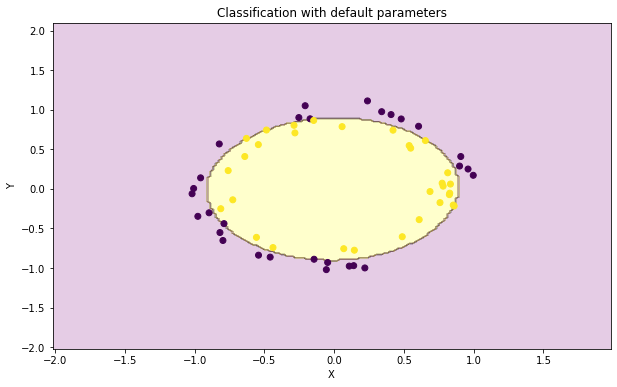

In [8]:
# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))
grid_results

# create a mesh to plot in
x_min, x_max = X_test["x"].min() - 1, X_test["x"].max() + 1
y_min, y_max = X_test["y"].min() - 1, X_test["y"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
Z = results.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.2, colors = ['purple', "black", "yellow", "black"])

# Plot also the training points

plt.scatter(X_test["x"], X_test["y"], c=y_test)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Classification with default parameters")

plt.show()

# 1.4 Hyperparameter Tuning with Random Search

Whereas a full grid search is a exhaustive search for the performing parameter combinations, random search is a more efficient alternative focusing on a hand full of randomly choosen parameter combinations.

Literature:
* *James Bergstra and Yoshua Bengio. (2012) Random search for hyper-parameter optimization. J. Mach. Learn. Res. 13, 281–305. https://dl.acm.org/doi/pdf/10.5555/2188385.2188395*

In [9]:
# Set up Random Search
grid = RandomizedSearchCV(svm.SVC(random_state=0, class_weight="balanced"), # initialize the SVM
                          param_distributions = {'C': uniform(loc=0, scale=10),  # define possible hyperparameter ranges
                                                 'kernel':["rbf", "linear", "poly", "sigmoid"],
                                                 'gamma':uniform(loc=0, scale=1)},
                          n_iter=200, # maximum number of combinations to try
                          cv = ShuffleSplit(n_splits=5, random_state=20220715), # define cross-validation splits with random seed
                          verbose=1,
                          random_state=20220715, # random seed to ensure reproducability of results
                          scoring='f1_micro', # which performance measure to use for evaluation of testset during cv
                          n_jobs=-1) # how many jobs are allowed to run in parallel? -1 means using all processors

# Save results in dataframe
results = grid.fit(X_train, y_train) # actual hyperparameter tuning
random_results = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


We can observe the difference between the two approaches visually. The following plot shows all tested parameter combinations by the grid search (with black edges) and by the random search (without black edges). The color of each point shows the average classification performance of the model.  


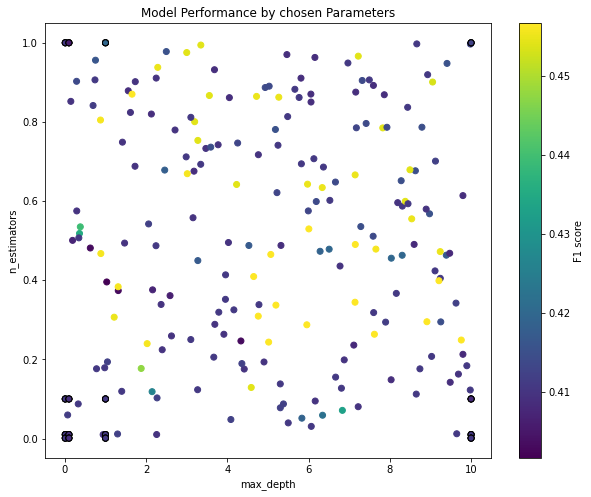

In [10]:
#Plot parameters and performance
plt.figure(figsize=(10, 8))
plt.scatter(random_results["C"], random_results["gamma"], c = random_results["Accuracy"])
plt.scatter(grid_results["C"], grid_results["gamma"], c = grid_results["Accuracy"], edgecolors="black")

plt.title("Model Performance by chosen Parameters")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")

# Plot color bar
a = np.arange(round(min(random_results["Accuracy"]),2), round(max(random_results["Accuracy"]),2), 0.01)
cbar = plt.colorbar()
cbar.set_label('F1 score')
cbar.ax.set_yticklabels([round(x,2) for x in a ])

plt.show()

# 2.0 Real-world Data Preparation


Preprocessing is a crucial step before working with real data. In this case, we transform categorical features into numerical features using Label Encoding.

In [11]:
# Load adults data
colnames = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
            "occupation", "relationship", "race", "sex", "capital-gain",
            "capital-loss", "hours-per-week", "native-country", "income"]
adults_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=colnames)
adults_df = adults_df.sample(frac=0.25) # shrink dataset for demonstration purposes

# Encode categorical features
le = LabelEncoder() # functionality to replace categorie names of a feature with numbers (e.g. Sales = 0, Exec-managerial = 1,...)
adults_df["occupation"] = le.fit_transform(adults_df["occupation"])
adults_df["race"] = le.fit_transform(adults_df["race"])
adults_df["sex"] = le.fit_transform(adults_df["sex"])

# Select features and split into train and test set
features=["age", "occupation", "race", 
          "capital-gain", "capital-loss",
          "hours-per-week", "sex", "education-num"]

X_train, X_test, y_train, y_test = train_test_split(
    adults_df[features], adults_df["income"], test_size=0.2, random_state=20220725) # the columns in features are our predictors, income is the feature to be predicted

In [12]:
adults_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
29578,32,Private,108116,Bachelors,13,Married-civ-spouse,3,Husband,4,1,0,1902,60,United-States,>50K
27016,47,Private,173938,Bachelors,13,Married-civ-spouse,3,Husband,4,1,0,0,57,United-States,>50K
26328,28,Private,145284,HS-grad,9,Divorced,13,Not-in-family,4,1,0,0,70,United-States,<=50K
8553,20,Private,211968,Assoc-voc,11,Never-married,7,Own-child,4,0,0,0,20,United-States,<=50K
9857,61,Self-emp-not-inc,96073,Prof-school,15,Married-civ-spouse,9,Husband,4,1,0,0,50,England,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25236,45,Private,168598,12th,8,Married-civ-spouse,1,Wife,2,0,3103,0,40,United-States,>50K
1556,23,Private,315877,Bachelors,13,Never-married,1,Not-in-family,4,1,0,0,30,United-States,<=50K
17662,33,Private,184306,Bachelors,13,Married-civ-spouse,9,Husband,4,1,0,0,45,United-States,<=50K
7715,24,Private,249351,HS-grad,9,Married-civ-spouse,6,Wife,4,0,0,0,40,United-States,<=50K


# 2.1 Random Forest

For this example, we first use a RandomForest classifier, as it usually shows a high performance compared to other classifiers.

Random forest is an ensemble classifier that fits multiple decision tree classifiers on various sub-samples of the dataset. These sub-classifications are averaged which improves the predictive accuracy and controls over-fitting. 

Literature:
  * *Quinlan, J.R. Induction of decision trees. (1986) Mach Learn 1, 81–106. https://doi.org/10.1007/BF00116251*
  * *Breiman, L. Random Forests. (2001) Machine Learning 45, 5–32. https://doi.org/10.1023/A:1010933404324*


In [13]:
# Train classifier with default parameters
clf = RandomForestClassifier(random_state=20220725)
clf.fit(X_train, y_train) # adapt the random forest algorithm to our training data

# Predict on test set
y_pred = clf.predict(X_test) # do an out-of-sample prediction on the test set using our trained classifier

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.7974067048256991


In [14]:
# Implement Tuning Pipeline
param_grid = [
  {'n_estimators': randint(1,50),
   'criterion': ["gini", "entropy"],
   'max_depth': randint(1,50),
   'class_weight': ["balanced", None]}
  ]

# Set up Random Search
grid = RandomizedSearchCV(RandomForestClassifier(), 
                          param_distributions = param_grid, 
                          n_iter=100, 
                          verbose=1,
                          random_state=20220725, 
                          refit=True,
                          n_jobs=-1)

# Save results in dataframe
results = grid.fit(X_train, y_train)
df_results = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["F1 Score"])],axis=1)

# Print best params
print(grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'n_estimators': 41}


In [15]:
# Implement Tuning Pipeline
param_grid = [
  {'n_estimators': [1, 5, 10, 20, 50],
   'criterion': ["gini", "entropy"],
   'max_depth': [1, 5, 10, 20, 50],
   'class_weight': ["balanced", None]}
  ]

# Define the search Grid
grid = GridSearchCV(RandomForestClassifier(), # initialize the SVM
                  param_grid = param_grid,
                  cv = ShuffleSplit(n_splits=5, random_state=20220715), # define cross-validation splits with random seed
                  verbose=10,                     
                  scoring='f1_micro',
                  n_jobs=-1)

# Run the GridSearch
results = grid.fit(X_train, y_train)
grid_results = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["F1 Score"])],axis=1)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [16]:
# Predict with best model
y_pred = results.best_estimator_.predict(X_test)

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.8142602162989968


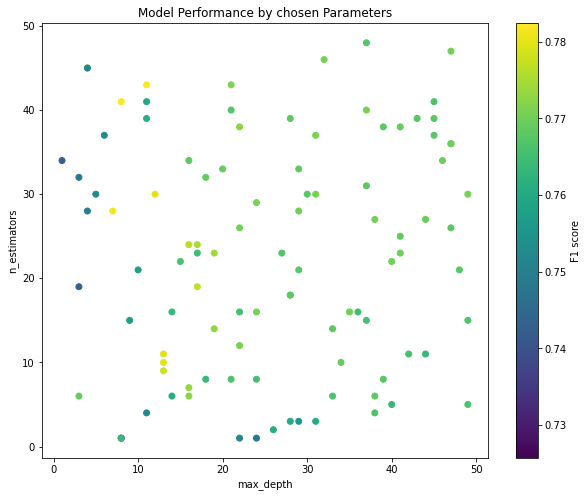

In [17]:
# Plot parameters and performance
plt.figure(figsize=(10, 8))
plt.scatter(df_results["max_depth"], df_results["n_estimators"], c = df_results["F1 Score"])
plt.title("Model Performance by chosen Parameters")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")

# Plot color bar
a = np.arange(round(min(df_results["F1 Score"]),2), round(max(df_results["F1 Score"]),2), 0.01)
cbar = plt.colorbar()
cbar.set_label('F1 score')
cbar.ax.set_yticklabels([round(x,2) for x in a ])

plt.show()

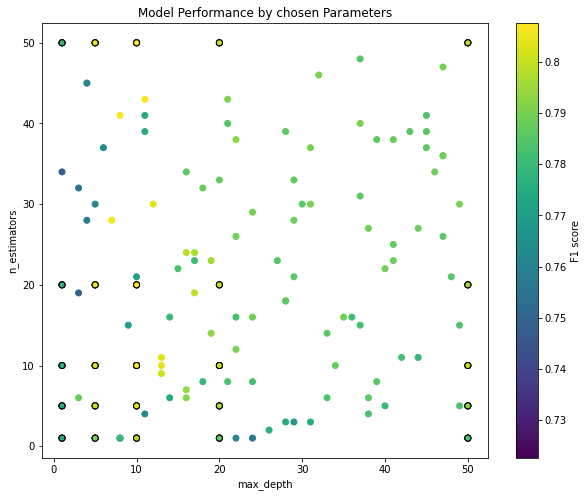

In [18]:
# Plot parameters and performance
plt.figure(figsize=(10, 8))
plt.scatter(df_results["max_depth"], df_results["n_estimators"], c = df_results["F1 Score"])
plt.scatter(grid_results["max_depth"], grid_results["n_estimators"], c = grid_results["F1 Score"], edgecolors="black")

plt.title("Model Performance by chosen Parameters")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")

# Plot color bar
a = np.arange(round(min(df_results["F1 Score"]),2), round(max(df_results["F1 Score"]),2), 0.01)
cbar = plt.colorbar()
cbar.set_label('F1 score')
cbar.ax.set_yticklabels([round(x,2) for x in a ])

plt.show()

# 2.2 XGBoost

The decision-tree boosting algorithm XGBoost (Extreme Gradient Boosting) is widely to solve regression, classification as well as ranking problems.

Literature:
  * *Chen et al., XGBoost: A Scalable Tree Boosting System. (2016) KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785-794. https://doi.org/10.1145/2939672.2939785*

In [19]:
# Train classifier with default parameters
clf = XGBClassifier(random_state=20220725)
clf.fit(X_train, y_train) # adapt the random forest algorithm to our training data

# Predict on test set
y_pred = clf.predict(X_test) # do an out-of-sample prediction on the test set using our trained classifier

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.8235576319123161


In [20]:
# Implement Tuning Pipeline
param_grid = [
              {'max_depth': randint(3, 20),
               'gamma': randint(1, 10),
               'eta': np.random.uniform(0.01, 0.2, 100),
               'n_estimators': randint(1, 200)
               }
              ]

# Set up Random Search
grid = RandomizedSearchCV(XGBClassifier(), 
                          param_distributions = param_grid, 
                          n_iter=100, 
                          verbose=1,
                          random_state=20220725, 
                          refit=True,
                          n_jobs=-1)

# Save results in dataframe
results = grid.fit(X_train, y_train)
df_results = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["F1 Score"])],axis=1)

# Print best params
print(grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'eta': 0.1923483703786158, 'gamma': 2, 'max_depth': 5, 'n_estimators': 170}


In [21]:
# Implement Tuning Pipeline
param_grid = [
              {'max_depth': [1, 2, 5, 10, 20],
               'gamma': [1, 2, 4, 10],
               'eta': np.random.uniform(0.01, 0.2, 5),
               'n_estimators': [1, 2, 5, 10, 25]
               }
              ]

# Define the search Grid
grid = GridSearchCV(XGBClassifier(), # initialize the SVM
                  param_grid = param_grid,
                  cv = ShuffleSplit(n_splits=5, random_state=20220715), # define cross-validation splits with random seed
                  verbose=10,                     
                  scoring='f1_micro',
                  n_jobs=-1)

# Run the GridSearch
results = grid.fit(X_train, y_train)
grid_results = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["F1 Score"])],axis=1)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [22]:
# Predict with best model
y_pred = results.best_estimator_.predict(X_test)

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.8239800075266943


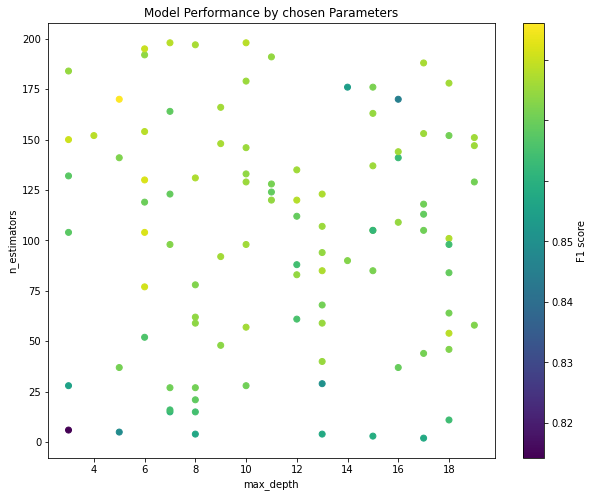

In [23]:
# Plot parameters and performance
plt.figure(figsize=(10, 8))
plt.scatter(df_results["max_depth"], df_results["n_estimators"], c = df_results["F1 Score"])
plt.title("Model Performance by chosen Parameters")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")

# Plot color bar
a = np.arange(round(min(df_results["F1 Score"]),2), round(max(df_results["F1 Score"]),2), 0.01)
cbar = plt.colorbar()
cbar.set_label('F1 score')
cbar.ax.set_yticklabels([round(x,2) for x in a ])

plt.show()

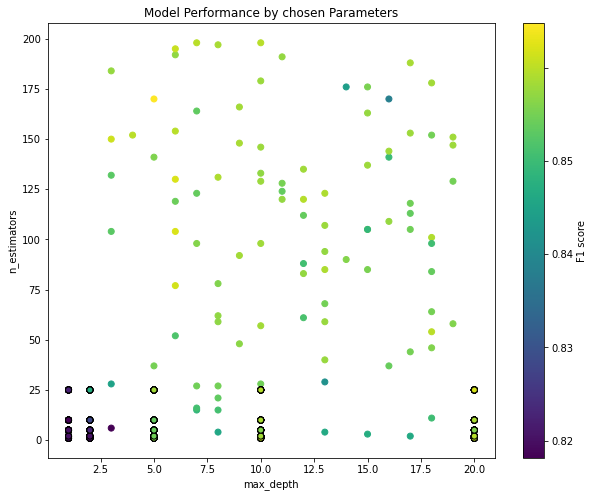

In [24]:
# Plot parameters and performance
plt.figure(figsize=(10, 8))
plt.scatter(df_results["max_depth"], df_results["n_estimators"], c = df_results["F1 Score"])
plt.scatter(grid_results["max_depth"], grid_results["n_estimators"], c = grid_results["F1 Score"], edgecolors="black")

plt.title("Model Performance by chosen Parameters")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")

# Plot color bar
a = np.arange(round(min(df_results["F1 Score"]),2), round(max(df_results["F1 Score"]),2), 0.01)
cbar = plt.colorbar()
cbar.set_label('F1 score')
cbar.ax.set_yticklabels([round(x,2) for x in a ])

plt.show()

# 3.1 Visualizing the problem of under- and overfitting and how to overcome it

In the following we first draw a random set of two-dimensional points from a normal distribution to apply a simple Decision Tree classifier on.
We focus on three scenarios:
1.   Underfitting using to less tree branches (max_depth=1)
2.   Overfitting using all possible tree branches (max_depth=None)
3.   Showing a good fit by doing a hyperparameter grid search over a defined grid

In [25]:
# Decision Tree Comparison underfitting, overfitting and hyperparameter tuning
# Dataset generation
n_points = 75
mu, sigma = 0, 0.4

# First class (blue)
zeros = np.zeros((n_points), dtype=int)
np.random.seed(1)
x_zeros = 0.7 + (np.random.normal(mu, sigma, n_points))*0.6
np.random.seed(220)
y_zeros = 0.3 + (np.random.normal(mu, sigma, n_points))*0.6

# Second class (orange)
ones = np.ones((n_points), dtype=int)
np.random.seed(500)
x_ones = 0.4 + (np.random.normal(mu, sigma, n_points))*0.6
np.random.seed(5000)
y_ones = 0.6 + (np.random.normal(mu, sigma, n_points))*0.6

df_zeros = pd.DataFrame({'x': x_zeros,'y': y_zeros,'class' : zeros})
df_ones = pd.DataFrame({'x': x_ones,'y': y_ones,'class' : ones})
df = pd.concat([df_zeros, df_ones], ignore_index=True, axis=0)

# Training data
X_train = df[['x','y']]
y_train = df[['class']]

# Underfitting
underfit = DecisionTreeClassifier(max_depth=1, random_state=4)
underfit.fit(X_train, y_train)
# Overfitting
overfit = DecisionTreeClassifier(max_depth=None, random_state=4)
overfit.fit(X_train, y_train)

# Hyperparameter Tuning
# Define the search Grid
grid = GridSearchCV(DecisionTreeClassifier(random_state=4),
                  param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]},
                  cv = ShuffleSplit(n_splits=5, random_state=123),
                  verbose=10,
                  scoring='f1_micro',
                  n_jobs=-1)
# Run the GridSearch
tune = grid.fit(X_train, y_train)
print(tune.best_params_)

# Produce a map of the predictions for a grid of points
xx, yy = np.meshgrid(np.arange(-0.3, 1.3, 0.001),np.arange(-0.3, 1.3, 0.001))
Z_underfit = underfit.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)
Z_overfit  = overfit.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)
Z_tune = tune.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
{'max_depth': 2}


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


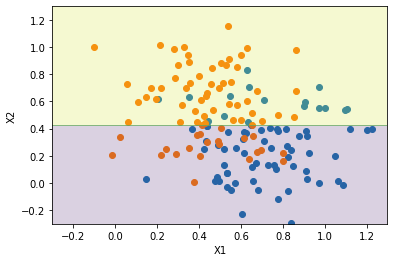

In [26]:
# Underfitting
f = plt.figure()
plt.scatter(x=x_zeros, y=y_zeros, cmap='viridis')
plt.scatter(x=x_ones, y=y_ones, cmap='viridis')
plt.contourf(xx, yy, Z_underfit, alpha=0.2, cmap='viridis')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

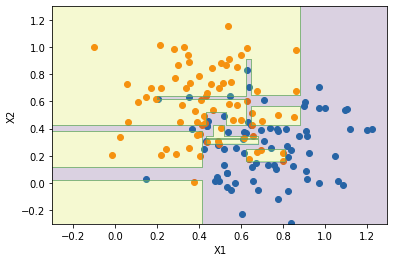

In [27]:
# Overfitting
f = plt.figure()
plt.scatter(x=x_zeros, y=y_zeros, cmap='viridis')
plt.scatter(x=x_ones, y=y_ones, cmap='viridis')
plt.contourf(xx, yy, Z_overfit, alpha=0.2, cmap='viridis')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

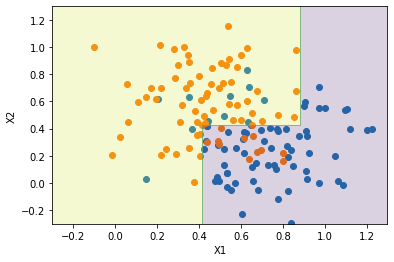

In [28]:
# Hyperparameter Tuning
f = plt.figure()
plt.scatter(x=x_zeros, y=y_zeros, cmap='viridis')
plt.scatter(x=x_ones, y=y_ones, cmap='viridis')
plt.contourf(xx, yy, Z_tune, alpha=0.2, cmap='viridis')
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()